In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [2]:
# --- 準備工作：讀取資料與定義變數意義 ---

file_path = 'working_population_health_data.csv'
df = pd.read_csv(file_path)

# 把代碼轉換成有意義的標籤

# 複製一份資料框來做轉換，保留原始數據
df_labeled = df.copy()

# 性別 v45
df_labeled['v45'] = df_labeled['v45'].map({1: '男性', 2: '女性'})

# 遠距工作 v24
df_labeled['v24'] = df_labeled['v24'].map({1: '是', 2: '否'})

# 下班後處理工作 v43
df_labeled['v43'] = df_labeled['v43'].map({1: '是', 2: '否'})

# 身體狀況變差 v33
# 簡化為二元變數：1和2代表「有變差」，3,4,5代表「沒有或變好」
df_labeled['v33_binary'] = df_labeled['v33'].apply(lambda x: '有變差' if x in [1, 2] else '沒有或變好')

# # 年齡分組 v4
# # 1-3: 12-29歲, 4-5: 30-49歲, 6-8: 50-69歲, 9-10: 70歲以上
# def age_group(code):
#     if code <= 3: return '青年 (12-29歲)'
#     if code <= 5: return '壯年 (30-49歲)'
#     if code <= 8: return '中年 (50-69歲)'
#     return '高齡 (70歲以上)'
# df_labeled['age_group'] = df_labeled['v4'].apply(age_group)

# 年齡分組 v4
def age_group(code):
    if code <= 2: return '15-19歲'
    if code <= 3: return '20-29歲'
    if code <= 4: return '30-39歲'
    if code <= 5: return '40-49歲'
    if code <= 6: return '50-59歲'
    return '60-69歲'
df_labeled['age_group'] = df_labeled['v4'].apply(age_group)


In [3]:
# ==============================================================================
# 步驟一：資料探索與描述性統計
# ==============================================================================
print("================== 步驟一：資料探索與描述性統計 ==================\n")

# 1. 檢視數值型變數的整體統計
print("數值變數統計摘要 (v34是幸福感, v42是AI焦慮, v41是網路工作%):")
print(df[['v34', 'v42', 'v41']].describe())
print("\n" + "="*50 + "\n")

# 2. 檢視類別型變數的分布
print("各類別變數人數分布:")
print("性別分布:\n", df_labeled['v45'].value_counts(), "\n")
print("年齡層分布:\n", df_labeled['age_group'].value_counts(), "\n")
print("下班後是否需處理公事:\n", df_labeled['v43'].value_counts(), "\n")
print("身體狀況是否變差:\n", df_labeled['v33_binary'].value_counts(), "\n")
print("\n" + "="*50 + "\n")


================== 步驟一：資料探索與描述性統計 ==================

數值變數統計摘要 (v34是幸福感, v42是AI焦慮, v41是網路工作%):
               v34          v42          v41
count  6664.000000  6664.000000  6664.000000
mean      7.214586     2.759004    56.748199
std       1.662646     0.892627    39.785643
min       0.000000     1.000000     0.000000
25%       6.000000     2.000000    10.000000
50%       7.000000     3.000000    70.000000
75%       8.000000     3.000000   100.000000
max      10.000000     4.000000   100.000000


各類別變數人數分布:
性別分布:
 v45
男性    3665
女性    2999
Name: count, dtype: int64 

年齡層分布:
 age_group
40-49歲    1904
50-59歲    1714
30-39歲    1377
60-69歲     847
20-29歲     785
15-19歲      37
Name: count, dtype: int64 

下班後是否需處理公事:
 v43
是    3689
否    2975
Name: count, dtype: int64 

身體狀況是否變差:
 v33_binary
有變差      3740
沒有或變好    2924
Name: count, dtype: int64 





In [4]:
# ==============================================================================
# 步驟二：假設驗證與雙變數分析
# ==============================================================================
print("================== 步驟二：假設驗證與雙變數分析 ==================\n")

# --- 假設1: 下班後處理公事(v43)是否影響主觀幸福感(v34)? ---
group_yes = df[df['v43'] == 1]['v34']
group_no = df[df['v43'] == 2]['v34']

# 執行獨立樣本T檢定
t_stat, p_value = stats.ttest_ind(group_yes, group_no, nan_policy='omit')

print("--- 假設1: 下班後工作 vs 幸福感 ---")
print(f"下班後要處理公事者的平均幸福感: {group_yes.mean():.2f}")
print(f"下班後不需處理公事者的平均幸福感: {group_no.mean():.2f}")
print(f"T檢定 P-value: {p_value:.4f}")
if p_value < 0.05:
    print("結果顯著：下班後是否處理公事，對於主觀幸福感有顯著差異。\n")
else:
    print("結果不顯著：下班後是否處理公事，對於主觀幸福感沒有顯著差異。\n")

# --- 假設2: 對AI的焦慮感(v42)越高，幸福感(v34)是否越低? ---
# 提醒：v42的分數越低代表越焦慮 (1=非常可能被取代)
corr, p_value_corr = stats.pearsonr(df['v42'], df['v34'])

print("--- 假設2: AI取代焦慮感 vs 幸福感 ---")
print(f"AI焦慮感與幸福感的皮爾森相關係數: {corr:.3f}")
print(f"P-value: {p_value_corr:.4f}")
if p_value_corr < 0.05:
    print("結果顯著：AI焦慮感與幸福感之間存在顯著的相關性。")
    if corr > 0:
        print("（解讀：AI焦慮程度越低(分數越高)，幸福感越高。）\n")
    else:
        print("（解讀：AI焦慮程度越高(分數越低)，幸福感越高。）\n")
else:
    print("結果不顯著：AI焦慮感與幸福感之間沒有顯著的相關性。\n")
    
# --- 假設3: 不同性別(v45)或年齡層在幸福感上是否有差異? ---
male_happiness = df[df['v45'] == 1]['v34']
female_happiness = df[df['v45'] == 2]['v34']
t_stat_gender, p_value_gender = stats.ttest_ind(male_happiness, female_happiness, nan_policy='omit')

print("--- 假設3: 性別 vs 幸福感 ---")
print(f"男性平均幸福感: {male_happiness.mean():.2f}")
print(f"女性平均幸福感: {female_happiness.mean():.2f}")
print(f"P-value: {p_value_gender:.4f}")
if p_value_gender < 0.05:
    print("結果顯著：男女在幸福感上存在顯著差異。\n")
else:
    print("結果不顯著：男女在幸福感上沒有顯著差異。\n")

print("\n" + "="*50 + "\n")



# --- 假設4: 身體狀況(v33)與主觀幸福感(v34)的關係 ---
# 先進行連續變數的相關性分析
corr_health_happiness, p_value_health = stats.pearsonr(df['v33'], df['v34'])

print("--- 假設4: 身體狀況 vs 幸福感 ---")
print(f"身體狀況與幸福感的皮爾森相關係數: {corr_health_happiness:.3f}")
print(f"P-value: {p_value_health:.4f}")

if p_value_health < 0.05:
    print("結果顯著：身體狀況與幸福感之間存在顯著的相關性。")
    if corr_health_happiness > 0:
        print("（解讀：身體狀況越好，幸福感越高。）\n")
    else:
        print("（解讀：身體狀況越差，幸福感越高。）\n")
else:
    print("結果不顯著：身體狀況與幸福感之間沒有顯著的相關性。\n")

# 再進行二元分類的差異比較
good_health = df[df['v33'] >= 3]['v34']  # 身體狀況沒變差或變好的人
poor_health = df[df['v33'] <= 2]['v34']  # 身體狀況變差的人

t_stat_health, p_value_health_binary = stats.ttest_ind(good_health, poor_health, nan_policy='omit')

print("--- 身體狀況類別比較 ---")
print(f"身體狀況沒變差或變好者的平均幸福感: {good_health.mean():.2f}")
print(f"身體狀況變差者的平均幸福感: {poor_health.mean():.2f}")
print(f"T檢定 P-value: {p_value_health_binary:.4f}")

if p_value_health_binary < 0.05:
    print("結果顯著：身體狀況不同，對於主觀幸福感有顯著差異。")
    if good_health.mean() > poor_health.mean():
        print("（解讀：身體狀況較好者，幸福感顯著較高。）\n")
    else:
        print("（解讀：身體狀況較差者，幸福感顯著較高。）\n")
else:
    print("結果不顯著：身體狀況不同，對於主觀幸福感沒有顯著差異。\n")

================== 步驟二：假設驗證與雙變數分析 ==================

--- 假設1: 下班後工作 vs 幸福感 ---
下班後要處理公事者的平均幸福感: 7.25
下班後不需處理公事者的平均幸福感: 7.17
T檢定 P-value: 0.0652
結果不顯著：下班後是否處理公事，對於主觀幸福感沒有顯著差異。

--- 假設2: AI取代焦慮感 vs 幸福感 ---
AI焦慮感與幸福感的皮爾森相關係數: 0.062
P-value: 0.0000
結果顯著：AI焦慮感與幸福感之間存在顯著的相關性。
（解讀：AI焦慮程度越低(分數越高)，幸福感越高。）

--- 假設3: 性別 vs 幸福感 ---
男性平均幸福感: 7.16
女性平均幸福感: 7.28
P-value: 0.0040
結果顯著：男女在幸福感上存在顯著差異。



--- 假設4: 身體狀況 vs 幸福感 ---
身體狀況與幸福感的皮爾森相關係數: 0.111
P-value: 0.0000
結果顯著：身體狀況與幸福感之間存在顯著的相關性。
（解讀：身體狀況越好，幸福感越高。）

--- 身體狀況類別比較 ---
身體狀況沒變差或變好者的平均幸福感: 7.40
身體狀況變差者的平均幸福感: 7.07
T檢定 P-value: 0.0000
結果顯著：身體狀況不同，對於主觀幸福感有顯著差異。
（解讀：身體狀況較好者，幸福感顯著較高。）



--- 假設4: 身體狀況 vs 幸福感 ---
身體狀況與幸福感的皮爾森相關係數: 0.111
P-value: 0.0000
結果顯著：身體狀況與幸福感之間存在顯著的相關性。
（解讀：身體狀況越好，幸福感越高。）

--- 不同身體狀況等級的幸福感比較 (ANOVA) ---
身體狀況=1 的平均幸福感: 6.93 (n=1400)
身體狀況=2 的平均幸福感: 7.15 (n=2340)
身體狀況=3 的平均幸福感: 7.40 (n=2917)
身體狀況=4 的平均幸福感: 8.25 (n=4)
身體狀況=5 的平均幸福感: 8.00 (n=3)
ANOVA F-statistic: 20.88
P-value: 0.0000


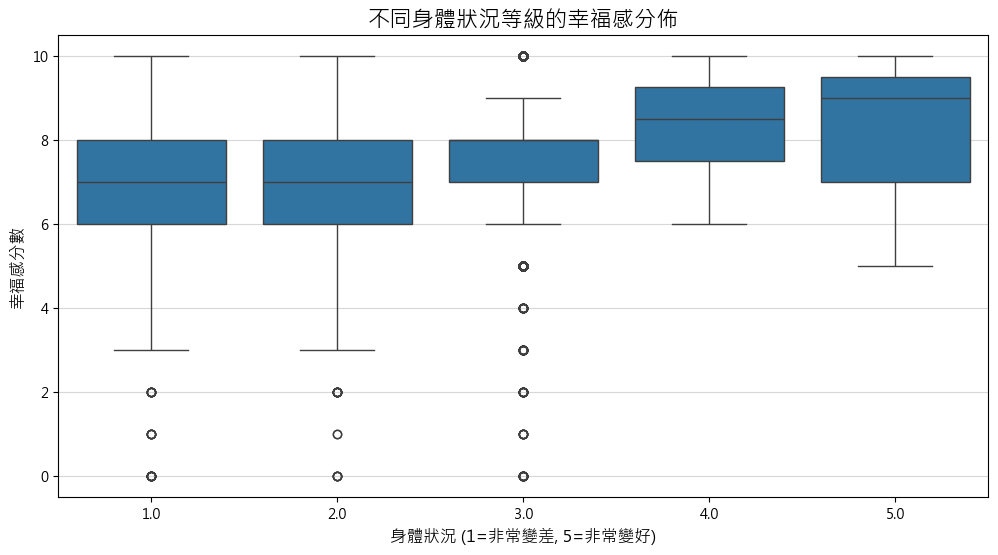

In [9]:
# --- 假設4: 身體狀況(v33)與主觀幸福感(v34)的關係 ---
# 先進行連續變數的相關性分析
corr_health_happiness, p_value_health = stats.pearsonr(df['v33'], df['v34'])

print("--- 假設4: 身體狀況 vs 幸福感 ---")
print(f"身體狀況與幸福感的皮爾森相關係數: {corr_health_happiness:.3f}")
print(f"P-value: {p_value_health:.4f}")

if p_value_health < 0.05:
    print("結果顯著：身體狀況與幸福感之間存在顯著的相關性。")
    if corr_health_happiness > 0:
        print("（解讀：身體狀況越好，幸福感越高。）\n")
    else:
        print("（解讀：身體狀況越差，幸福感越高。）\n")
else:
    print("結果不顯著：身體狀況與幸福感之間沒有顯著的相關性。\n")

## 使用ANOVA分析不同身體狀況等級的幸福感差異
groups = [df[df['v33'] == i]['v34'] for i in range(1, 6)]
f_stat, p_value_anova = stats.f_oneway(*groups)

print("--- 不同身體狀況等級的幸福感比較 (ANOVA) ---")
for i in range(1, 6):
    group = df[df['v33'] == i]['v34']
    print(f"身體狀況={i} 的平均幸福感: {group.mean():.2f} (n={len(group)})")
print(f"ANOVA F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value_anova:.4f}")

# 設定中文字體，以避免亂碼
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # for Windows
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# 視覺化 - 箱形圖展示各等級的幸福感分佈
plt.figure(figsize=(12, 6))
sns.boxplot(x='v33', y='v34', data=df)
plt.title('不同身體狀況等級的幸福感分佈', fontsize=16)
plt.xlabel('身體狀況 (1=非常變差, 5=非常變好)', fontsize=12)
plt.ylabel('幸福感分數', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

In [6]:

# ==============================================================================
# 步驟三：建立綜合模型 (多元迴歸分析)
# ==============================================================================
print("==================== 步驟三：建立綜合模型 ====================\n")
print("目標：同時考慮所有因素，找出影響幸福感(v34)的最關鍵變數。\n")

# 準備迴歸模型的資料
# Y 是依變數 (我們要預測的目標)
Y = df['v34']
# X 是自變數 (我們用來預測的因素)
# C(v43)表示將v43視為類別變數
X = df[['v4', 'v45', 'v24', 'v41', 'v43', 'v42', 'v33', 'v8', 'v38']] 
X = sm.add_constant(X) # 加入截距項

# 建立並擬合模型
model = sm.OLS(Y, X, missing='drop').fit() # missing='drop'會自動處理缺失值

# 打印出完整的迴歸分析報告
print("--- 多元迴歸分析結果 ---")
print(model.summary())

==================== 步驟三：建立綜合模型 ====================

目標：同時考慮所有因素，找出影響幸福感(v34)的最關鍵變數。

--- 多元迴歸分析結果 ---
                            OLS Regression Results                            
Dep. Variable:                    v34   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     33.30
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           6.92e-58
Time:                        00:21:32   Log-Likelihood:                -12697.
No. Observations:                6664   AIC:                         2.541e+04
Df Residuals:                    6654   BIC:                         2.548e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

# 解讀迴歸報告
## 1. R-squared: 模型解釋力。此模型可以解釋幸福感變異的百分比
## 2. coef (係數): 每個變數的影響力
- 正數：此變數增加，幸福感傾向增加
- 負數：此變數增加，幸福感傾向降低
## 3. P>|t| (P-value): 顯著性。如果 < 0.05，表示這個變數是影響幸福感的顯著預測因子
找出P值小於0.05的那些變數

In [7]:
print("==================== 步驟三：建立綜合模型 ====================\n")
print("目標：同時考慮所有因素，找出影響身體(v33)的最關鍵變數。\n")

# 準備迴歸模型的資料
# Y 是依變數 (我們要預測的目標)
Y = df['v33']
# X 是自變數 (我們用來預測的因素)
# C(v43)表示將v43視為類別變數
X = df[['v4', 'v45', 'v24', 'v41', 'v43', 'v42', 'v8', 'v38']] 
X = sm.add_constant(X) # 加入截距項

# 建立並擬合模型
model = sm.OLS(Y, X, missing='drop').fit() # missing='drop'會自動處理缺失值

# 打印出完整的迴歸分析報告
print("--- 多元迴歸分析結果 ---")
print(model.summary())

==================== 步驟三：建立綜合模型 ====================

目標：同時考慮所有因素，找出影響身體(v33)的最關鍵變數。

--- 多元迴歸分析結果 ---
                            OLS Regression Results                            
Dep. Variable:                    v33   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     64.59
Date:                Thu, 23 Oct 2025   Prob (F-statistic):          2.03e-102
Time:                        00:21:32   Log-Likelihood:                -7511.6
No. Observations:                6664   AIC:                         1.504e+04
Df Residuals:                    6655   BIC:                         1.510e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

====================== 步驟四：資料視覺化 ======================



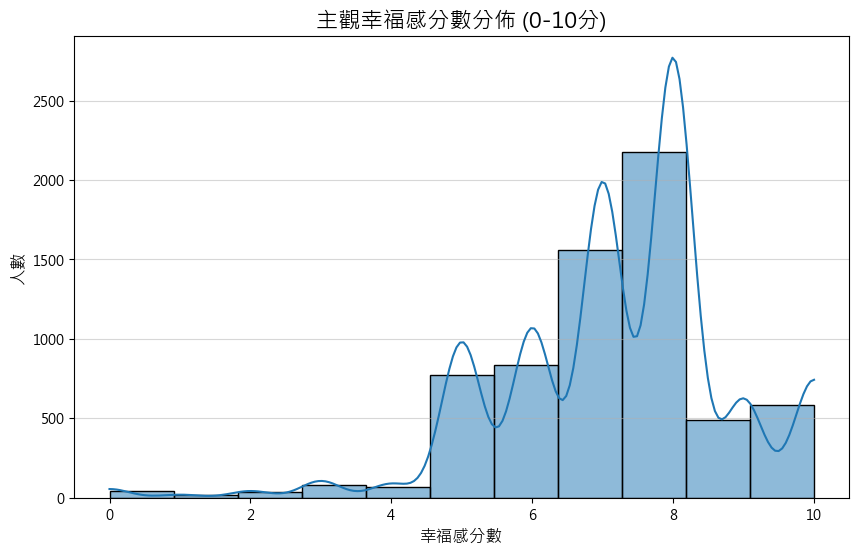

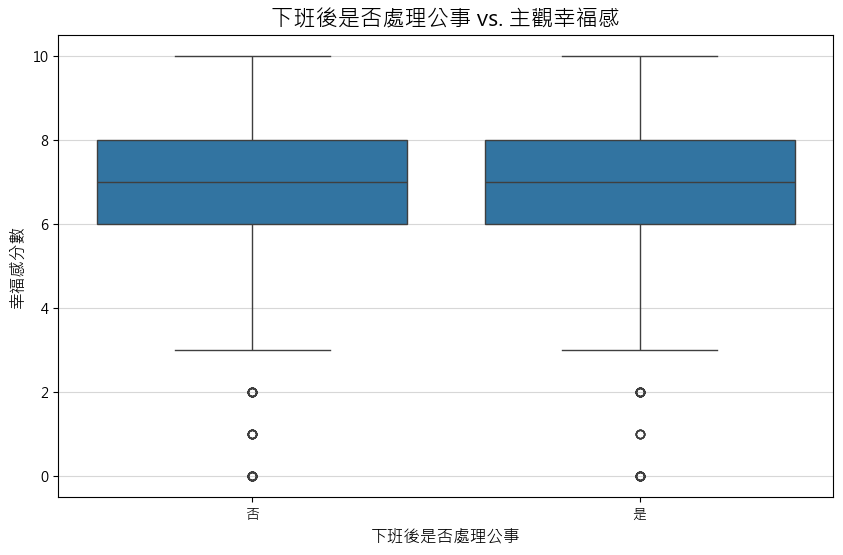

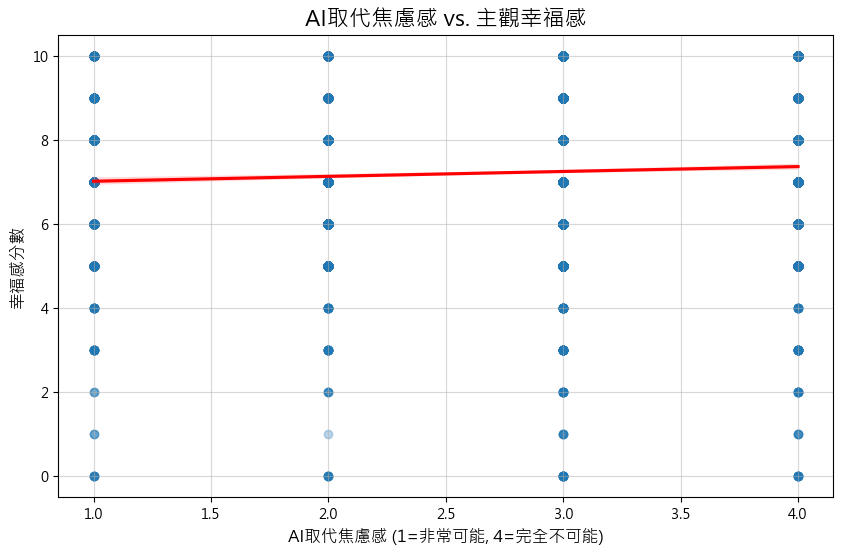

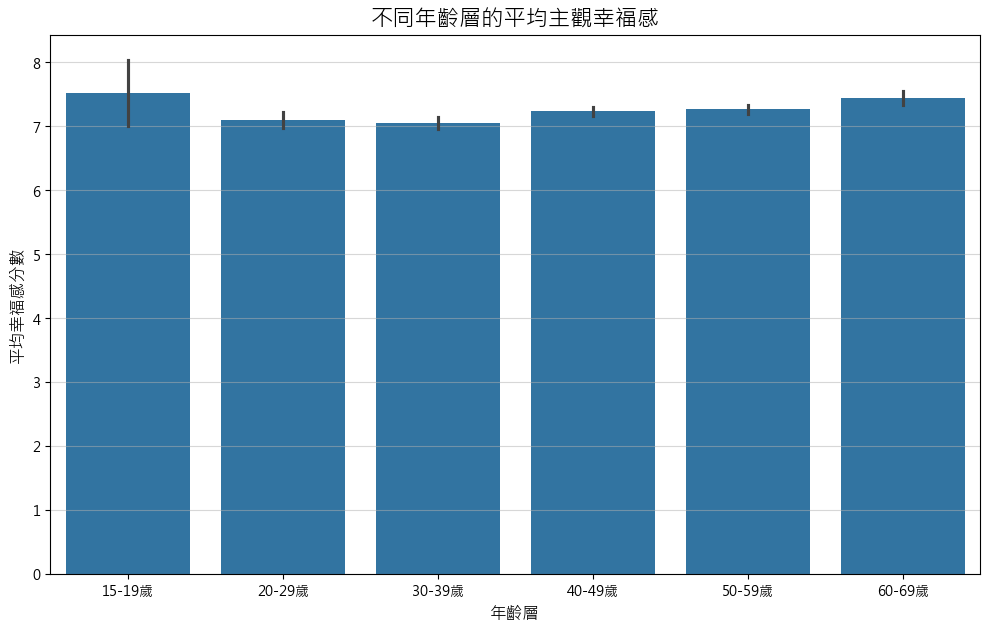

In [8]:
# ==============================================================================
# 步驟四：資料視覺化
# ==============================================================================
print("====================== 步驟四：資料視覺化 ======================\n")

# 設定中文字體，以避免亂碼
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # for Windows
plt.rcParams['axes.unicode_minus'] = False # 正常顯示負號

# 圖1: 幸福感分數分佈圖 (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['v34'], bins=11, kde=True)
plt.title('主觀幸福感分數分佈 (0-10分)', fontsize=16)
plt.xlabel('幸福感分數', fontsize=12)
plt.ylabel('人數', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

# 圖2: 下班後工作 vs 幸福感 (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='v43', y='v34', data=df_labeled)
plt.title('下班後是否處理公事 vs. 主觀幸福感', fontsize=16)
plt.xlabel('下班後是否處理公事', fontsize=12)
plt.ylabel('幸福感分數', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

# 圖3: AI焦慮感 vs 幸福感 (Scatterplot with Regression Line)
plt.figure(figsize=(10, 6))
sns.regplot(x='v42', y='v34', data=df, line_kws={"color": "red"}, scatter_kws={'alpha':0.3})
plt.title('AI取代焦慮感 vs. 主觀幸福感', fontsize=16)
plt.xlabel('AI取代焦慮感 (1=非常可能, 4=完全不可能)', fontsize=12)
plt.ylabel('幸福感分數', fontsize=12)
plt.grid(True, alpha=0.5)
plt.show()

# 圖4: 年齡層 vs 幸福感 (Barplot with error bars)
plt.figure(figsize=(12, 7))
sns.barplot(x='age_group', y='v34', data=df_labeled, order=['15-19歲','20-29歲','30-39歲','40-49歲','50-59歲','60-69歲'])
plt.title('不同年齡層的平均主觀幸福感', fontsize=16)
plt.xlabel('年齡層', fontsize=12)
plt.ylabel('平均幸福感分數', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

# 深入分析一：探討交互作用 — 「下班後工作」對男女的幸福感影響是否不同？

這個分析的目的是檢驗**性別(v45)是否調節了下班後工作(v43)對幸福感(v34)**的影響。簡單來說，就是看「加班壓力」這件事，對男性和女性的幸福感打擊程度是否不一樣。

方法： 我們將在原本的多元迴歸模型中，加入一個「性別 * 下班後工作」的交互作用項。

==================== 深入分析一：交互作用模型 ====================

--- 目標：檢驗「下班後工作」對男女幸福感的影響是否不同 ---

                            OLS Regression Results                            
Dep. Variable:                    v34   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     30.07
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           2.54e-57
Time:                        00:22:41   Log-Likelihood:                -12696.
No. Observations:                6664   AIC:                         2.541e+04
Df Residuals:                    6653   BIC:                         2.549e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
---

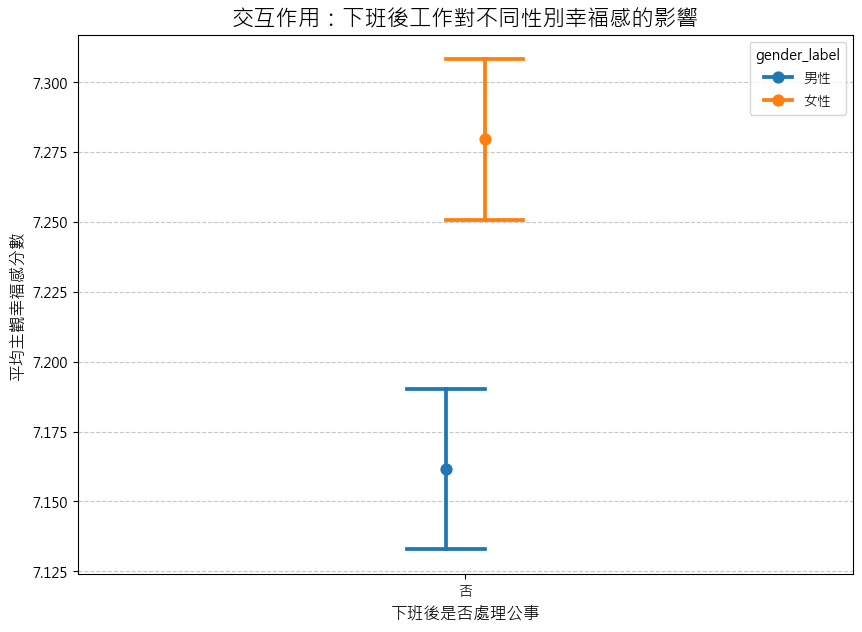

In [10]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# --- 準備工作：為了模型解讀方便，我們將核心類別變數重新編碼 ---
# 這是最佳實踐，讓迴歸係數的意義更直觀
df_recoded = df.copy()

# v43 (下班後處理工作): 1=是, 2=否 -> 重新編碼為 1=是, 0=否
df_recoded['work_after_hours'] = df_recoded['v43'].apply(lambda x: 1 if x == 1 else 0)

# v45 (性別): 1=男性, 2=女性 -> 重新編碼為 0=男性, 1=女性
df_recoded['gender_recoded'] = df_recoded['v45'].apply(lambda x: 0 if x == 1 else 1)

# --- 建立帶有交互作用項的迴歸模型 ---
# 使用 formula API 可以更直觀地定義模型
# 'C(variable)' 表示將該變數視為類別變數
# 'C(gender_recoded):C(work_after_hours)' 就是我們的交互作用項
interaction_model_formula = """
v34 ~ v4 + C(gender_recoded) + v24 + v41 + C(work_after_hours) + 
      v42 + v33 + v8 + v38 + 
      C(gender_recoded):C(work_after_hours)
"""

interaction_model = smf.ols(formula=interaction_model_formula, data=df_recoded).fit()

print("==================== 深入分析一：交互作用模型 ====================\n")
print("--- 目標：檢驗「下班後工作」對男女幸福感的影響是否不同 ---\n")
print(interaction_model.summary())


# --- 視覺化交互作用 ---
# 為了圖表標籤好看，我們也在df_labeled上做同樣的重新編碼
df_labeled_recoded = df_labeled.copy()
df_labeled_recoded['work_after_hours_label'] = df_labeled_recoded['v43'].apply(lambda x: '是' if x == 1 else '否')
df_labeled_recoded['gender_label'] = df_labeled_recoded['v45']

plt.figure(figsize=(10, 7))
sns.pointplot(data=df_labeled_recoded, x='work_after_hours_label', y='v34', hue='gender_label', dodge=True, errorbar='se', capsize=.1)
plt.title('交互作用：下班後工作對不同性別幸福感的影響', fontsize=16)
plt.xlabel('下班後是否處理公事', fontsize=12)
plt.ylabel('平均主觀幸福感分數', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 如何解讀結果

1.看迴歸模型的表格：
- 在輸出的迴歸模型摘要中，找到最下面那一行，名為 C(gender_recoded)[T.1]:C(work_after_hours)[T.1] 的項目。這就是交互作用項。
- 關鍵看它的 P>|t| (p-value)。
    - 如果 p < 0.05： 恭喜！這表示交互作用顯著。意思是，「下班後工作」對幸福感的影響，真的會因為你是男性或女性而有所不同。
    - 如果 p > 0.05： 這表示交互作用不顯著。意思是，雖然下班後工作本身可能（或不可能）有影響，但這種影響在男女之間沒有統計上的顯著差異。

2.看視覺化圖表：
- 這張圖會畫出男性和女性兩條線。
- 如果兩條線幾乎是平行的： 代表交互作用不顯著。
- 如果兩條線不平行（例如交叉，或一條線的斜率比另一條陡峭很多）： 這就是交互作用的視覺證據。你可以直觀地看出，從「否」到「是」，哪個群體的幸福感下降得更多。

# 深入分析二：針對「遠距工作者」的分群研究
這個分析的目的是想知道，在只看遠距工作者(v24=1)這個特定群體時，影響他們幸福感的因素是什麼？這是否和整體在職者的情況有所不同？
方法： 我們先篩選出所有遠距工作者，然後對這個子樣本重新跑一次原本的多元迴歸模型。

In [11]:
# --- 準備工作：篩選出遠距工作者的資料 ---
df_remote_workers = df[df['v24'] == 1].copy()

print(f"==================== 深入分析二：遠距工作者分群研究 ====================\n")
print(f"原始樣本數: {len(df)}，篩選出遠距工作者樣本數: {len(df_remote_workers)}\n")


# --- 對遠距工作者子樣本，建立多元迴歸模型 ---
# Y 是依變數 (幸福感)
Y_remote = df_remote_workers['v34']

# X 是自變數 (注意：我們不再需要把 v24 放進去，因為這個群體裡 v24 的值都是一樣的)
X_remote = df_remote_workers[['v4', 'v45', 'v41', 'v43', 'v42', 'v33', 'v8', 'v38']] 
X_remote = sm.add_constant(X_remote) # 加入截距項

# 建立並擬合模型
remote_model = sm.OLS(Y_remote, X_remote, missing='drop').fit()

# 打印出遠距工作者群體的迴歸分析報告
print("--- 遠距工作者群體的幸福感影響因素分析 ---")
print(remote_model.summary())

==================== 深入分析二：遠距工作者分群研究 ====================

原始樣本數: 6664，篩選出遠距工作者樣本數: 1695

--- 遠距工作者群體的幸福感影響因素分析 ---
                            OLS Regression Results                            
Dep. Variable:                    v34   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     12.02
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           8.24e-17
Time:                        00:22:46   Log-Likelihood:                -3059.7
No. Observations:                1695   AIC:                             6137.
Df Residuals:                    1686   BIC:                             6186.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

### 如何解讀結果
1.對比兩個迴歸模型： 拿出這個**「遠距工作者模型」的結果，和您之前跑的「全體在職者模型」**的結果並排比較。

2.尋找差異點：
- 顯著性改變： 有沒有哪些變數在全體模型中不顯著，但在遠距模型中變得顯著了？反之亦然？
    - 例如： 也許「工作內容使用網路比例(v41)」在全體模型中影響微弱，但在遠距模型中，它的係數(coef)變得更大且更顯著。這可能說明，對遠距工作者來說，工作的高度數位化與他們的幸福感關聯更強。
- 影響力（係數）改變： 比較兩個模型中相同變數的coef值。
    - 例如： 也許「下班後工作(v43)」在全體模型中不顯著，但在遠距模型中，它的p-value變小了（即使仍不顯著），且負向係數變大。這可能暗示，對遠距工作者來說，工作與生活界線的模糊化問題更為嚴重。